# Feature Selection

In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy.stats import chi2_contingency

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('../Data/after_feature_engineering.pkl', 'rb') as f:
    df_train = pickle.load(f)
    df_valid = pickle.load(f)
    df_test = pickle.load(f)
    df_train_encoded = pickle.load(f)
    df_valid_encoded = pickle.load(f)
    df_test_encoded = pickle.load(f)

df_train_encoded.head()

,unit_id,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,...,green_space_ratio,estimated_maintenance_cost,global_economic_index,obj_type_0d6c4dfc,obj_type_2a6d5c01,obj_type_Unknown,build_mat_7f8c00f9,build_mat_Unknown,has_lift_no,has_lift_yes
45366,f13df795472bee05,59.39,3.0,3.0,4.0,1980.0,2.578,19.0,0.326,0.462,...,1.000,17.98,93.327971,0,0,1,0,1,1,0
86630,003ffcbd3294c3c9,52.95,2.0,2.0,6.0,2023.0,8.413,13.0,0.387,1.423,...,0.999,24.08,94.280615,1,0,0,0,1,0,1
139489,f5d1fc8f4a154cd4,24.55,2.0,2.0,4.0,1993.0,4.479,2.0,0.561,0.611,...,1.000,9.25,108.618716,1,0,0,0,1,1,0
24126,02376da3fe009bb0,57.58,3.0,3.0,3.0,2017.0,13.367,0.0,1.195,3.004,...,0.999,8.48,100.635935,0,0,1,0,1,0,1
151982,7b6bb74dcdff86a3,73.71,3.0,1.0,2.0,2016.0,9.365,0.0,2.159,4.349,...,0.999,24.94,93.385347,0,1,0,0,0,0,1


In [4]:
quantitative_cols = df_train.select_dtypes(include=[np.number]).columns
quantitative_cols

Index(['dim_m2', 'n_rooms', 'floor_no', 'floor_max', 'year_built',
       'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic', 'dist_post',
       'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma', 'price_z',
       'market_volatility', 'infrastructure_quality',
       'neighborhood_crime_rate', 'popularity_index', 'green_space_ratio',
       'estimated_maintenance_cost', 'global_economic_index'],
      dtype='object')

In [5]:
qualitative_cols = df_train.select_dtypes('object').columns
qualitative_cols

Index(['unit_id', 'obj_type', 'build_mat', 'has_park', 'has_balcony',
       'has_lift', 'has_sec', 'has_store', 'src_month', 'loc_code'],
      dtype='object')

In [6]:
numeric_correlations = df_train[quantitative_cols].corr(method = 'pearson')
numeric_correlations

,dim_m2,n_rooms,floor_no,floor_max,year_built,dist_centre,n_poi,dist_sch,dist_clinic,dist_post,...,dist_uni,dist_pharma,price_z,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
dim_m2,1.000000,0.764844,-0.067437,-0.122041,-0.008315,0.043345,0.031472,0.062423,0.014807,0.051594,...,0.039850,0.052812,0.539520,0.549842,0.011522,-0.000547,-0.000080,-0.042473,0.692743,-0.016099
n_rooms,0.764844,1.000000,-0.033562,-0.076970,0.002222,0.051778,0.000570,0.065951,0.039488,0.057016,...,0.051577,0.059733,0.475738,0.462929,0.001110,-0.000970,-0.002391,-0.048711,0.529219,-0.013060
floor_no,-0.067437,-0.033562,1.000000,0.684431,0.036390,-0.035679,0.042037,-0.107016,-0.133092,-0.082681,...,-0.072701,-0.108647,0.018018,0.025273,-0.035104,-0.002542,-0.002836,0.023672,-0.047334,0.009317
floor_max,-0.122041,-0.076970,0.684431,1.000000,0.079527,-0.038398,0.040131,-0.139825,-0.181233,-0.102438,...,-0.092989,-0.135994,0.043358,0.035807,-0.075598,0.001806,-0.003839,0.021144,-0.087672,0.012445
year_built,-0.008315,0.002222,0.036390,0.079527,1.000000,0.327439,-0.341724,0.243847,0.233358,0.219275,...,0.335137,0.186528,0.155483,0.114435,-0.921149,-0.003277,-0.003161,-0.278373,-0.006414,0.000248
dist_centre,0.043345,0.051778,-0.035679,-0.038398,0.327439,1.000000,-0.448654,0.280865,0.418226,0.253783,...,0.531408,0.244279,0.138251,0.081355,-0.302203,-0.006379,0.005492,-0.826239,0.030678,0.012266
n_poi,0.031472,0.000570,0.042037,0.040131,-0.341724,-0.448654,1.000000,-0.302385,-0.366946,-0.316574,...,-0.442513,-0.295678,0.151286,0.168293,0.315429,0.003857,-0.001391,0.311658,0.018242,-0.004696
dist_sch,0.062423,0.065951,-0.107016,-0.139825,0.243847,0.280865,-0.302385,1.000000,0.556135,0.747705,...,0.441463,0.793242,0.027947,-0.000319,-0.224365,-0.003669,-0.000168,-0.276299,0.042037,-0.001473
dist_clinic,0.014807,0.039488,-0.133092,-0.181233,0.233358,0.418226,-0.366946,0.556135,1.000000,0.492856,...,0.504941,0.509734,-0.086504,-0.101297,-0.215063,-0.002069,-0.000421,-0.383959,0.009800,0.005948
dist_post,0.051594,0.057016,-0.082681,-0.102438,0.219275,0.253783,-0.316574,0.747705,0.492856,1.000000,...,0.361494,0.791855,0.004152,-0.011361,-0.201274,-0.001685,0.000995,-0.231928,0.034485,-0.002376


<Axes: >

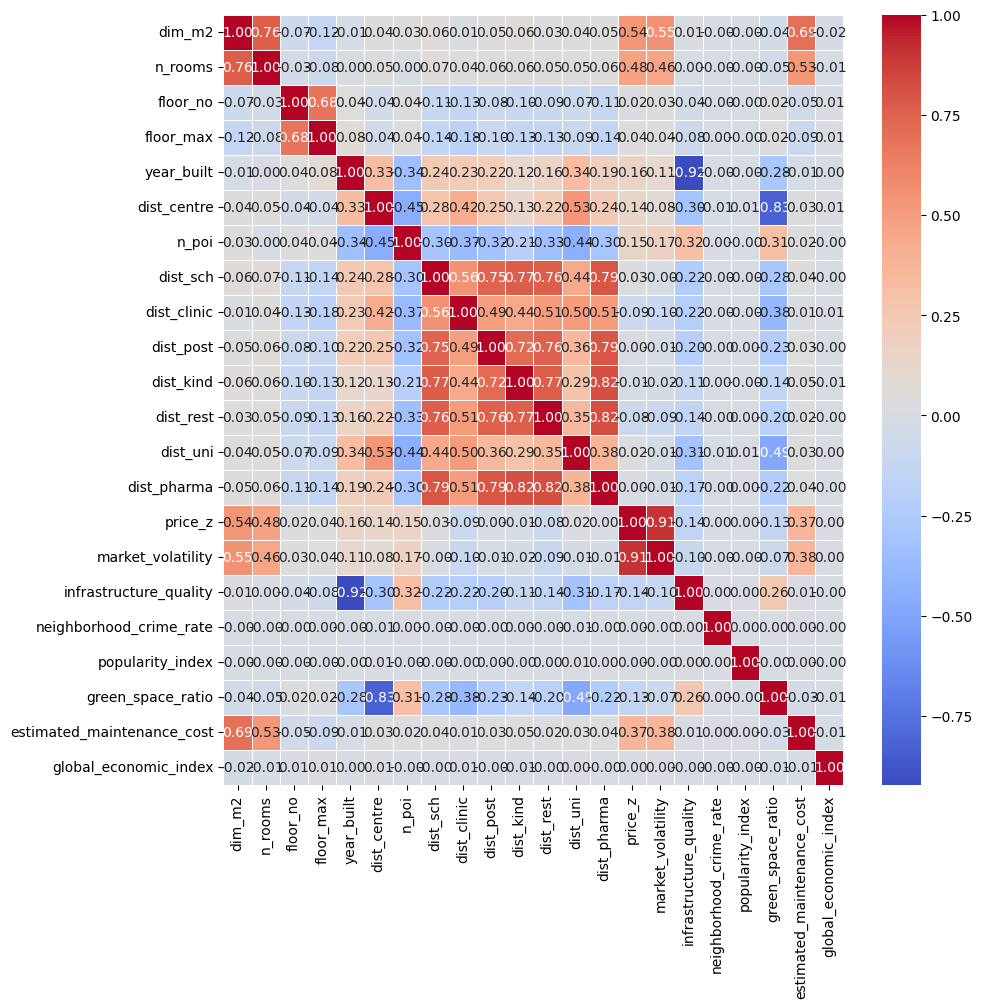

In [7]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    numeric_correlations,
    annot = True,
    cmap = 'coolwarm',
    fmt = '.2f',
    linewidth = 0.5
)

<Axes: >

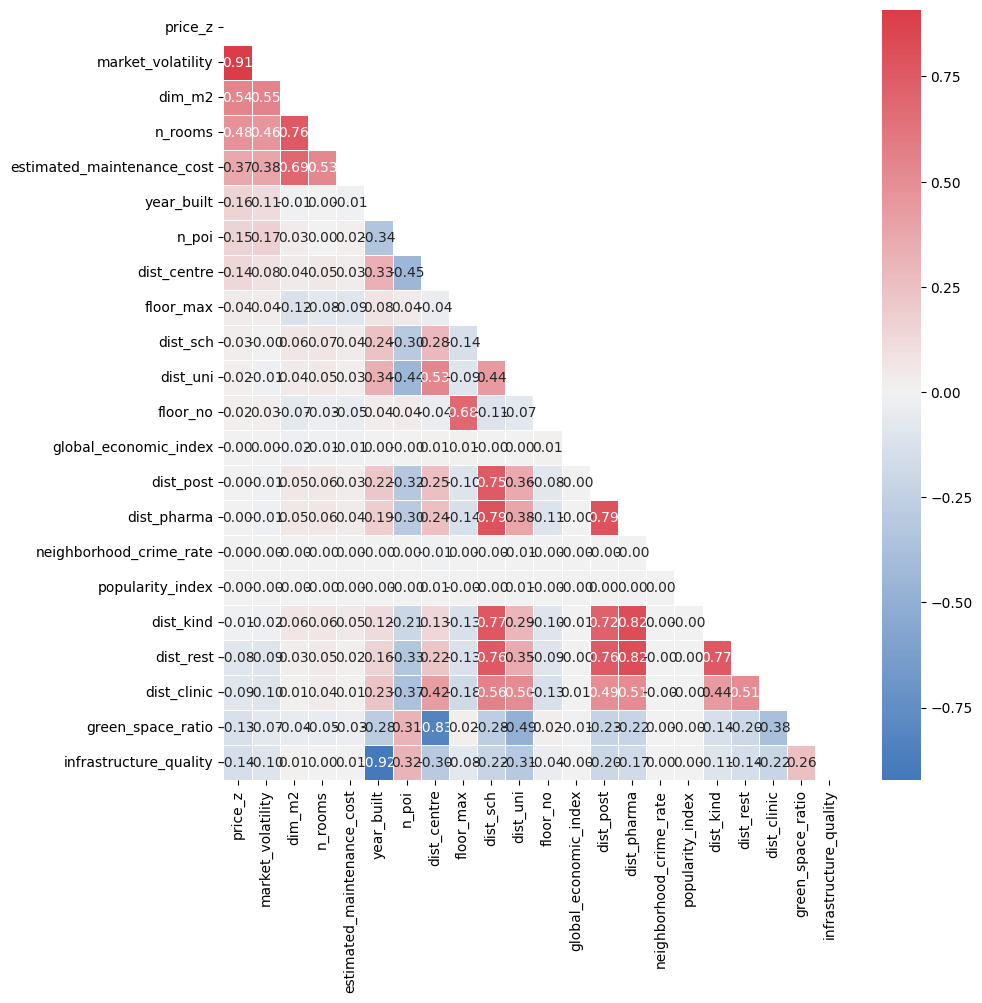

In [8]:
mask = np.triu(np.ones_like(numeric_correlations, dtype = bool))
correlations_with_y = numeric_correlations['price_z'].sort_values(
    ascending = False
)
ordered_columns = correlations_with_y.index

numeric_correlations = numeric_correlations[ordered_columns].loc[ordered_columns]

my_cmap = sns.diverging_palette(250, 10, as_cmap = True)

plt.figure(figsize = (10, 10))
sns.heatmap(
    numeric_correlations,
    annot = True,
    cmap = my_cmap,
    mask = mask,
    fmt = '.2f',
    linewidths = 0.5,
    center = 0
)

In [60]:
selected_numerical_variables = ['market_volatility', 'dim_m2', 'n_rooms', 
                        'estimated_maintenance_cost', 'year_built', 
                        'n_poi', 'dist_centre', 'green_space_ratio', 
                        'infrastructure_quality']

<Axes: >

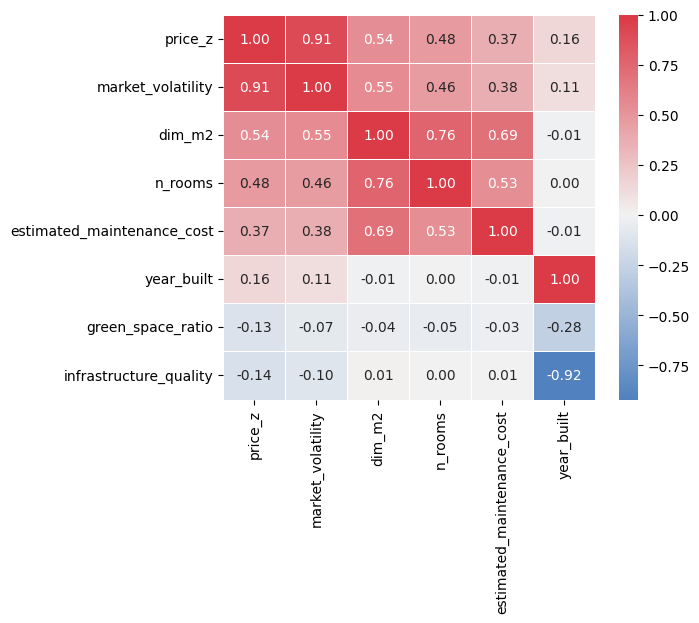

In [10]:
rows_to_plot = pd.concat([
    numeric_correlations.iloc[0:6],       # first 6 rows
    numeric_correlations.iloc[-2:]        # last 2 rows
])

plt.figure(figsize=(6, 5))
sns.heatmap(
    rows_to_plot.iloc[:, 0:6],  # first 6 columns (adjust if needed)
    annot=True,
    cmap=my_cmap,
    fmt='.2f',
    linewidths=0.5,
    center=0
)


order specifies the degree of the polynomial fit:

order=1 → linear fit

order=2 → quadratic fit

order=3 → cubic fit

…and so on.

It controls the curve of the regression line.

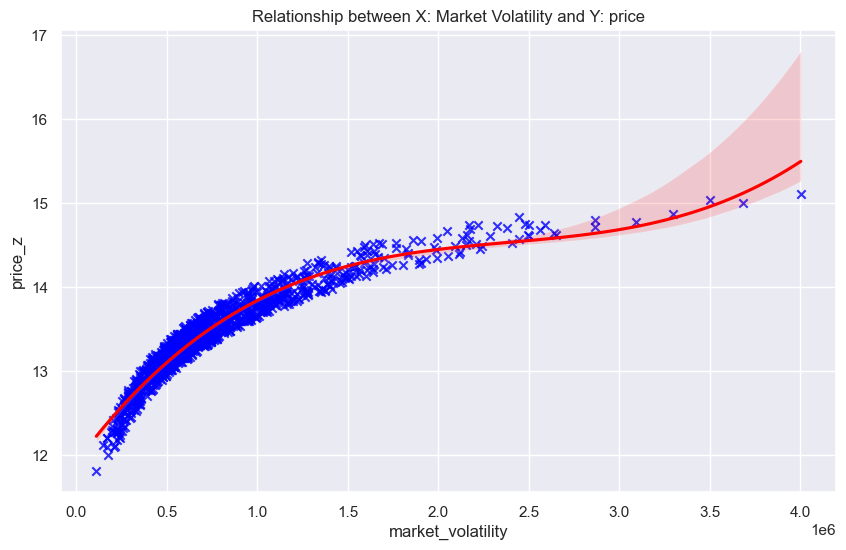

In [11]:
sns.set_theme()

plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'market_volatility',
    y = 'price_z',
    data = df_train.sample(1000, random_state = 123), # to select sub sample
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    order = 3, # higher order polynomial regression to capture nonlinear trends
    ci = 95, # confidence interval: 95%
    marker = 'x'
)

plt.title('Relationship between X: Market Volatility and Y: price')
plt.xlabel('market_volatility')
plt.ylabel('price_z')
plt.show()

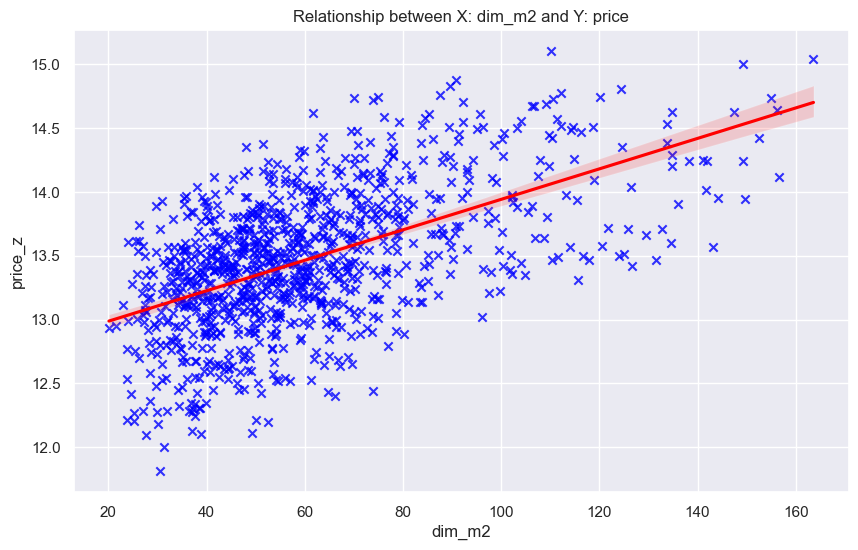

In [12]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'dim_m2',
    y = 'price_z',
    data = df_train.sample(1000, random_state = 123), # to select sub sample
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    order = 1, # higher order polynomial regression to capture nonlinear trends
    ci = 95, # confidence interval: 95%
    marker = 'x'
)

plt.title('Relationship between X: dim_m2 and Y: price')
plt.xlabel('dim_m2')
plt.ylabel('price_z')
plt.show()

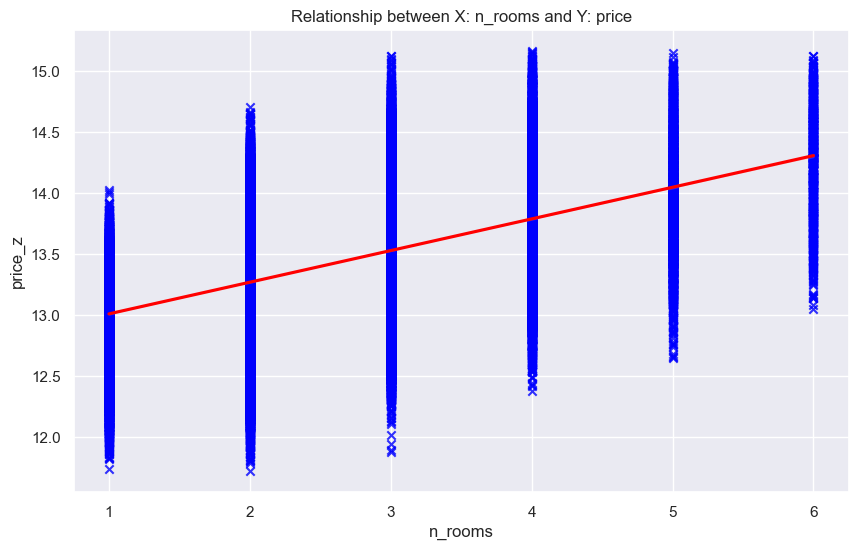

In [13]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'n_rooms',
    y = 'price_z',
    data = df_train, # to select sub sample
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    # order = 1, # higher order polynomial regression to capture nonlinear trends
    ci = 95, # confidence interval: 95%
    marker = 'x'
    # x_estimator=np.mean
)

plt.title('Relationship between X: n_rooms and Y: price')
plt.xlabel('n_rooms')
plt.ylabel('price_z')
plt.show()

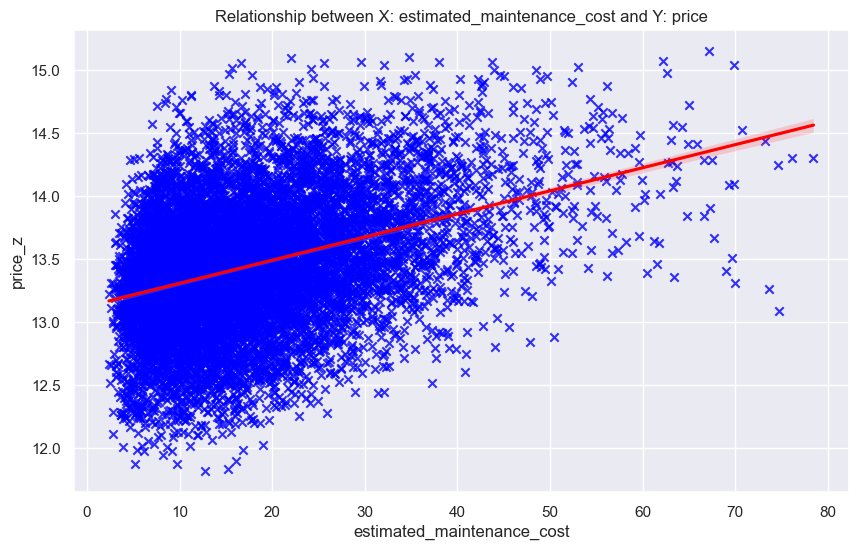

In [14]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'estimated_maintenance_cost',
    y = 'price_z',
    data = df_train.sample(10000, random_state = 123), # to select sub sample
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    order = 1, # higher order polynomial regression to capture nonlinear trends
    ci = 95, # confidence interval: 95%
    marker = 'x'
)

plt.title('Relationship between X: estimated_maintenance_cost and Y: price')
plt.xlabel('estimated_maintenance_cost')
plt.ylabel('price_z')
plt.show()

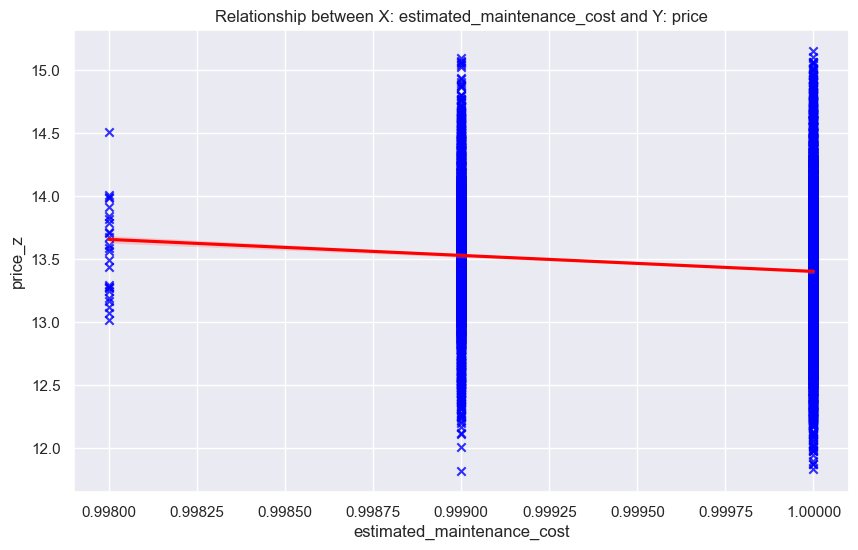

In [15]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'green_space_ratio',
    y = 'price_z',
    data = df_train.sample(10000, random_state = 123), # to select sub sample
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    order = 1, # higher order polynomial regression to capture nonlinear trends
    ci = 95, # confidence interval: 95%
    marker = 'x'
)

plt.title('Relationship between X: estimated_maintenance_cost and Y: price')
plt.xlabel('estimated_maintenance_cost')
plt.ylabel('price_z')
plt.show()

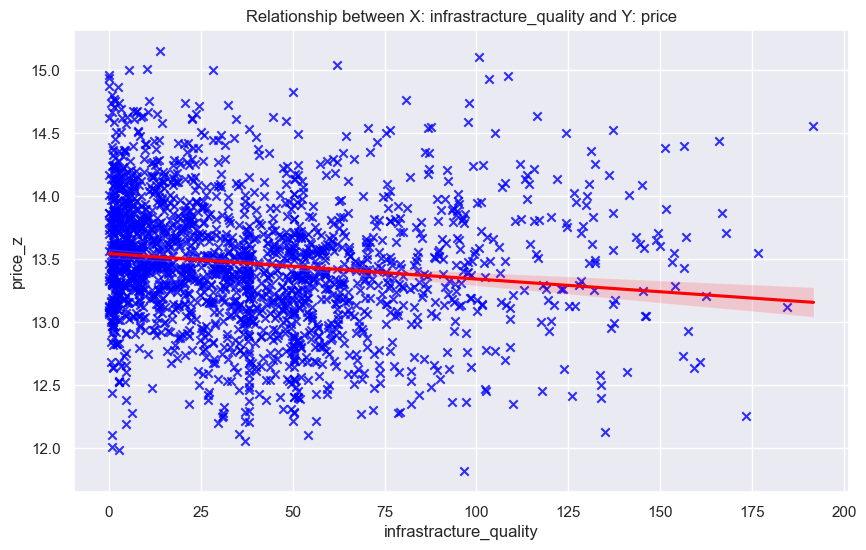

In [16]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'infrastructure_quality',
    y = 'price_z',
    data = df_train.sample(2000, random_state = 123), # to select sub sample
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    order = 1, # higher order polynomial regression to capture nonlinear trends
    ci = 95, # confidence interval: 95%
    marker = 'x'
)

plt.title('Relationship between X: infrastracture_quality and Y: price')
plt.xlabel('infrastracture_quality')
plt.ylabel('price_z')
plt.show()

## Qualitative Features

In [17]:
qualitative_cols

Index(['unit_id', 'obj_type', 'build_mat', 'has_park', 'has_balcony',
       'has_lift', 'has_sec', 'has_store', 'src_month', 'loc_code'],
      dtype='object')

In [23]:
import sys
sys.path.append('../src')  # adjust path if needed

# importing function from .py file
from anova_for_categorical_vars import anova_for_categorical_vars

In [26]:
def anova_for_categorical_vars(dataset, dep_var, cat_vars):
    results = [] # initialize a list to store the results
    for var in cat_vars:
        model = smf.ols(
            f'{dep_var} ~ C({var})',
            data = dataset
        ).fit()
        
        anova_table = anova_lm(model)
        
        # extract the F-statistic and p-value from the ANOVA table
        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]

        # append the results to the list
        results.append([var, f_statistic, p_value])

    # create a DataFrame with the results
    anova_results_df = pd.DataFrame(
        results,
        columns = ['Variable', 'F-statistic', 'p-value']
    )

    # sort the DataFrame by F-statistic in decreasing order
    # ascending = false, because we need to have most strongly correlated vars in first row
    anova_results_df = anova_results_df.sort_values(by = 'F-statistic', ascending = False)

    return anova_results_df

In [27]:
df_train[qualitative_cols].size

938720

In [28]:
# the size is huge, better to use sub-samples for faster results

sampled_df_train = df_train.sample(5000, random_state=123)

In [29]:
anova_results = anova_for_categorical_vars(
    sampled_df_train,
    'price_z',
    qualitative_cols
)

print(anova_results)

      Variable  F-statistic       p-value
9     loc_code   231.153335  0.000000e+00
7    has_store   202.086472  5.458389e-45
2    build_mat   160.400073  3.047044e-68
5     has_lift   145.793236  2.892642e-62
1     obj_type   137.377113  1.585655e-85
3     has_park   113.451780  3.276031e-26
6      has_sec    91.265278  1.913496e-21
4  has_balcony    46.579170  9.846299e-12
0      unit_id    14.173113  2.183806e-61
8    src_month     7.525847  5.306793e-12


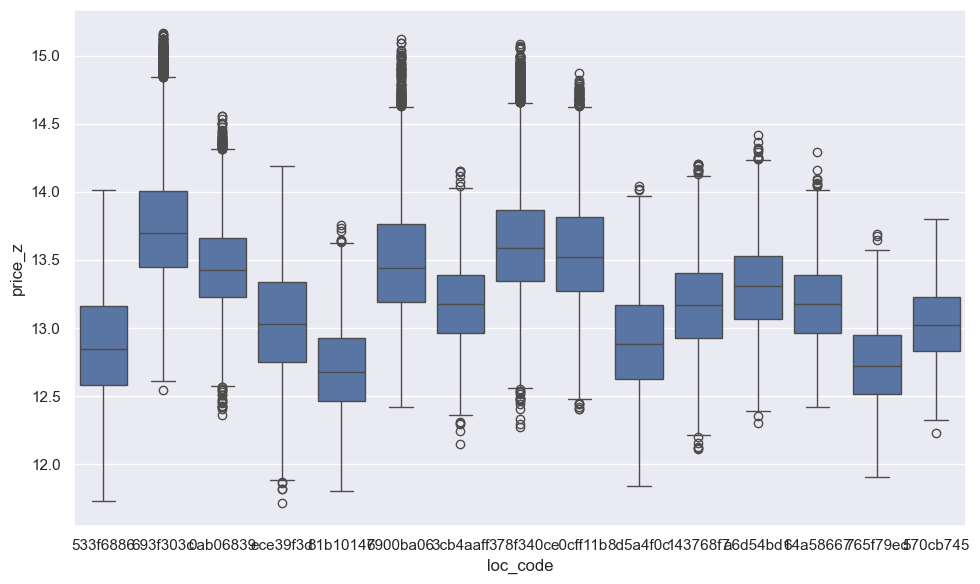

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'loc_code',
    y = 'price_z',
    data = df_train,
)
plt.tight_layout()
plt.show()

In [33]:
df_train['loc_code'].value_counts()

loc_code
693f303c    28417
378f340c    13886
0ab06839     9764
e0cff11b     9234
8d5a4f0c     7329
533f6886     4602
6900ba06     3984
a6d54bd1     3687
143768f7     3074
3cb4aaff     2735
ece39f3d     2499
765f79ed     1397
81b10147     1256
570cb745     1154
64a58667      854
Name: count, dtype: int64

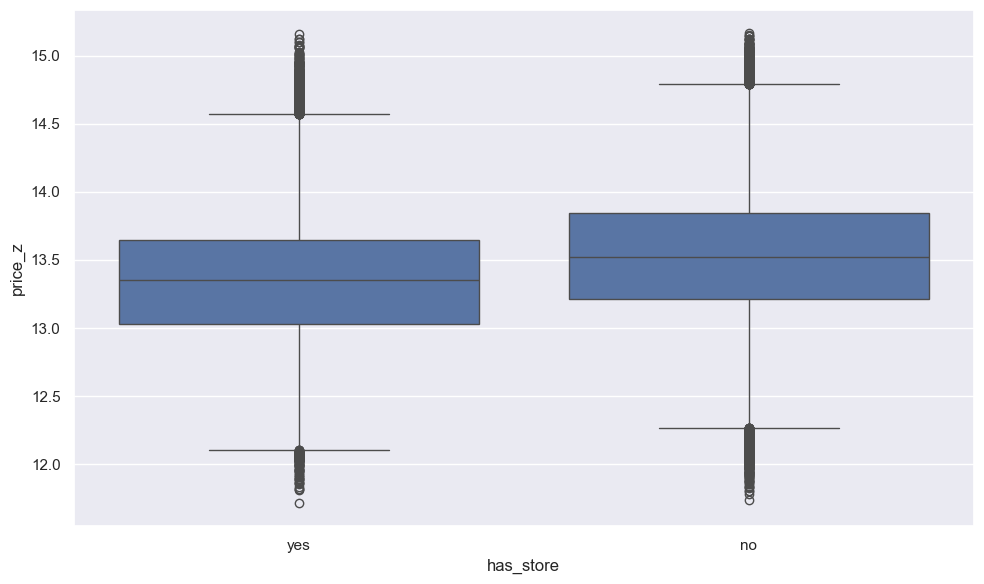

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'has_store',
    y = 'price_z',
    data = df_train,
)
plt.tight_layout()
plt.show()

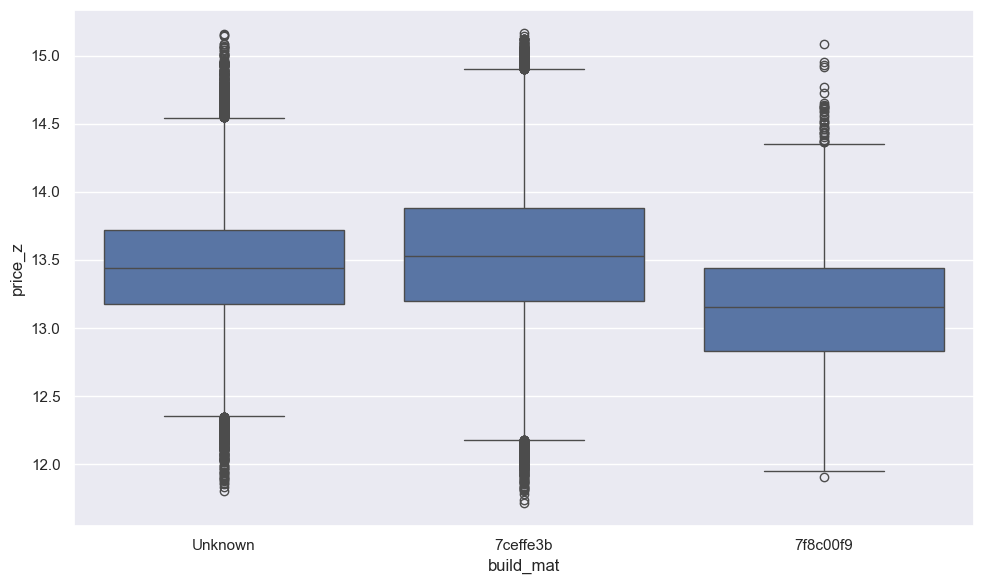

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'build_mat',
    y = 'price_z',
    data = df_train,
)
plt.tight_layout()
plt.show()

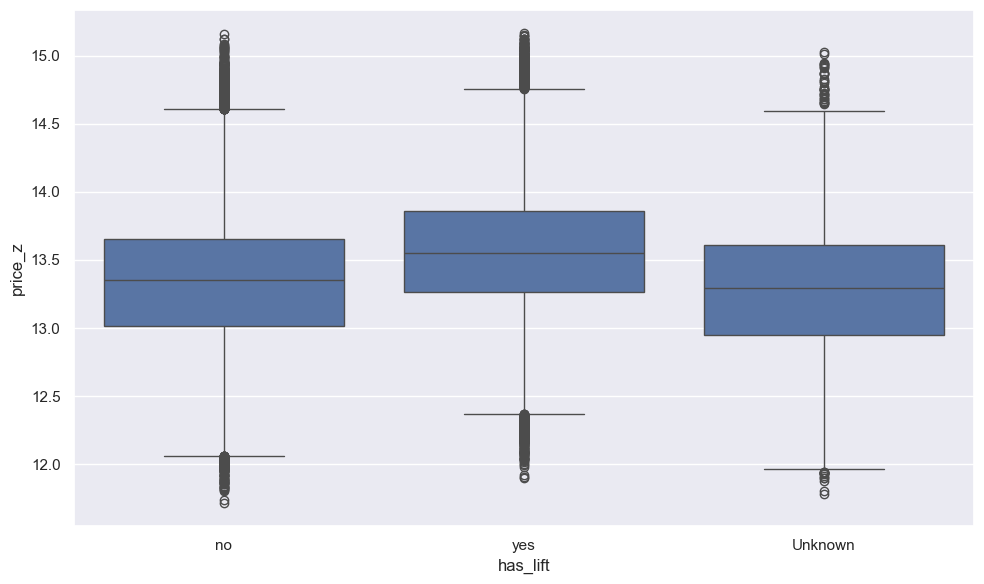

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'has_lift',
    y = 'price_z',
    data = df_train,
)
plt.tight_layout()
plt.show()

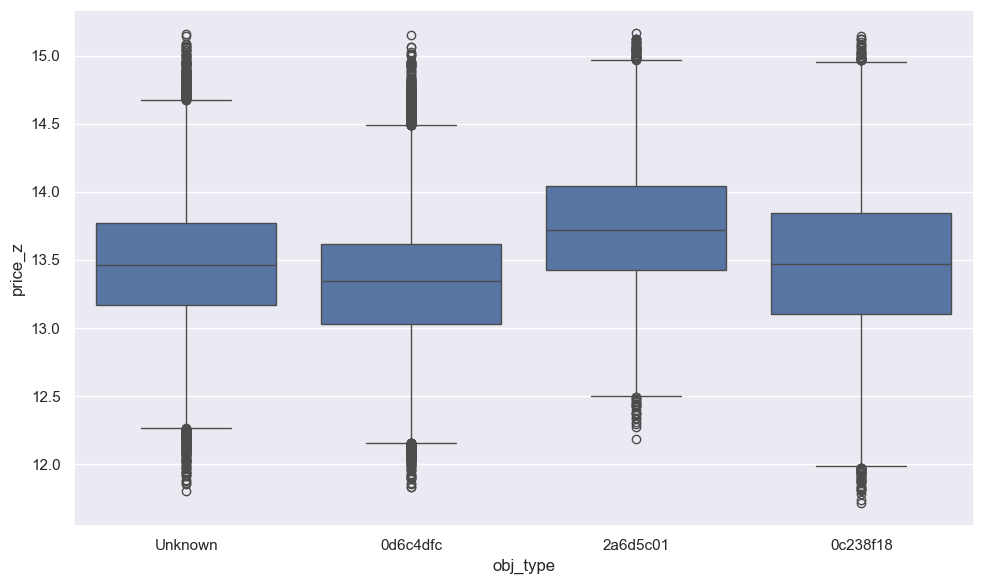

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'obj_type',
    y = 'price_z',
    data = df_train,
)
plt.tight_layout()
plt.show()

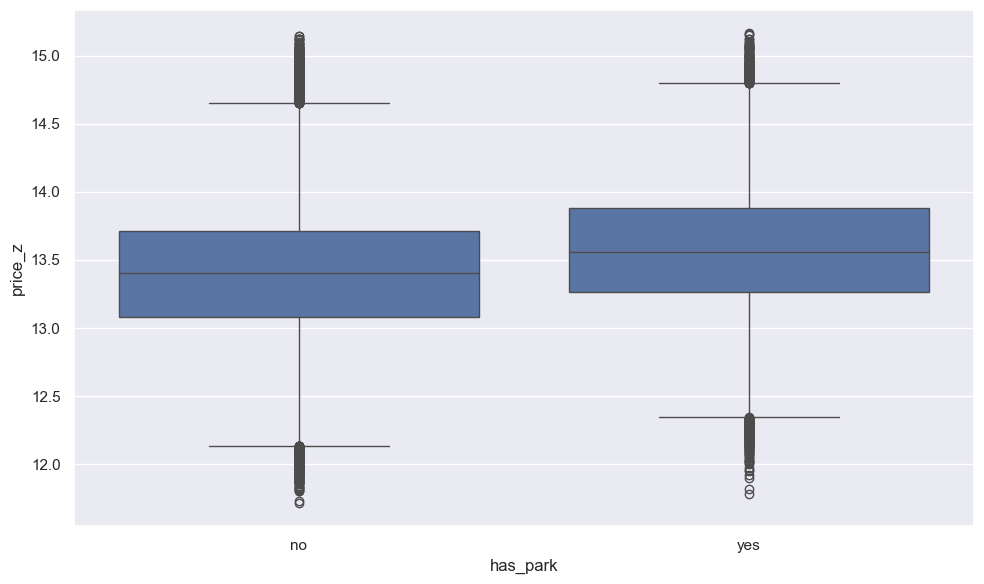

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'has_park',
    y = 'price_z',
    data = df_train,
)
plt.tight_layout()
plt.show()

In [43]:
import sys
sys.path.append('../src')  # adjust path if needed

# importing function from .py file
from cramersv import cramers_v, calculate_cramers_v_matrix

In [46]:
def cramers_v(contingency_table):
    ''' Calculate Cramer's V statistic from a contingency table. '''
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n*(min(contingency_table.shape) - 1)))


def calculate_cramers_v_matrix(dataset, cat_vars):
    ''' Calculate the Cramer's V for each pair of categorical variables. '''
    # create an empty matrix to store the results
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_vars), len(cat_vars))),
                                    columns=cat_vars,
                                    index=cat_vars)
    for i in range(len(cat_vars)):
        for j in range(i, len(cat_vars)):  # to avoid recalculating for the same pair
            var_1 = cat_vars[i]
            var_2 = cat_vars[j]

            # create a contingency table for the two variables
            contingency_table = pd.crosstab(dataset[var_1], dataset[var_2])

            # calculate Cramer's V
            cramers_v_value = cramers_v(contingency_table)

            cramers_v_matrix.loc[var_1, var_2] = cramers_v_value
            # symmetric matrix
            cramers_v_matrix.loc[var_2, var_1] = cramers_v_value

    return cramers_v_matrix


In [47]:
cramers_v_matrix = calculate_cramers_v_matrix(
    sampled_df_train,
    qualitative_cols
)

In [48]:
anova_results

,Variable,F-statistic,p-value
9,loc_code,231.153335,0.000000e+00
7,has_store,202.086472,5.458389e-45
2,build_mat,160.400073,3.047044e-68
5,has_lift,145.793236,2.892642e-62
1,obj_type,137.377113,1.585655e-85
3,has_park,113.451780,3.276031e-26
6,has_sec,91.265278,1.913496e-21
4,has_balcony,46.579170,9.846299e-12
0,unit_id,14.173113,2.183806e-61
8,src_month,7.525847,5.306793e-12


In [49]:
variables_order = anova_results['Variable'].tolist()

cramers_v_matrix = cramers_v_matrix[variables_order].loc[variables_order]

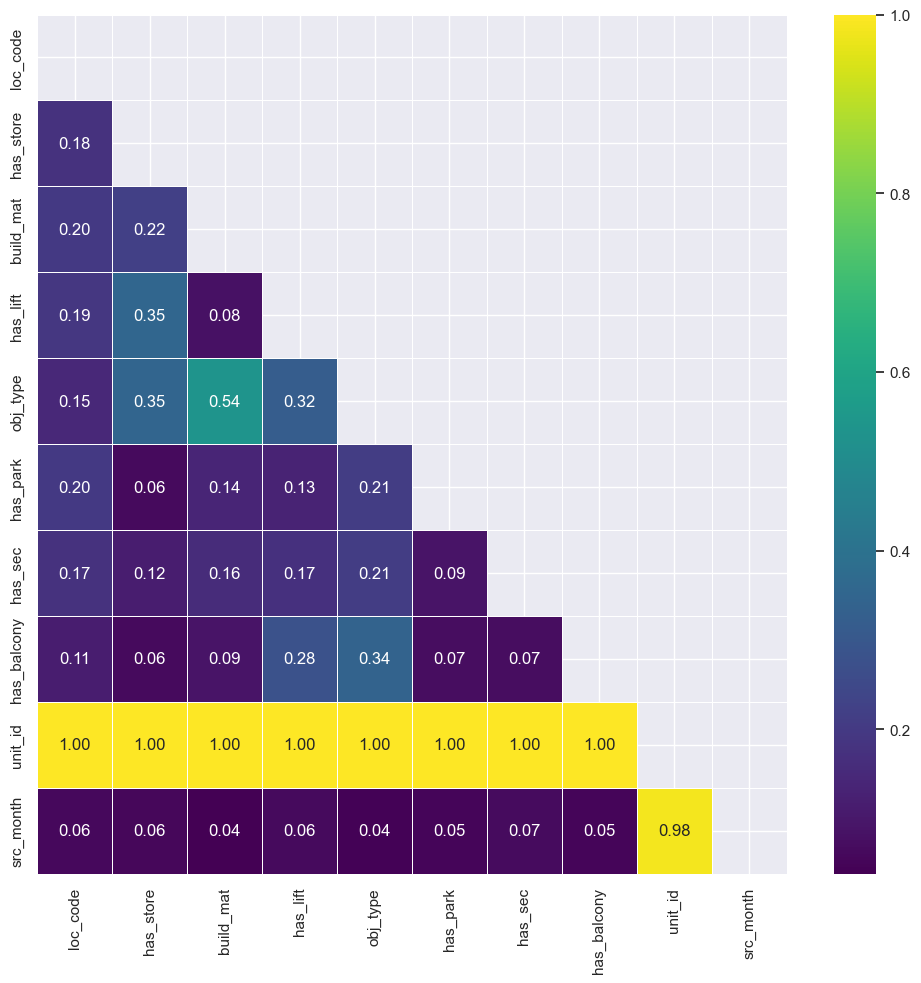

In [50]:
mask = np.triu(np.ones_like(cramers_v_matrix, dtype = bool))

plt.figure(figsize=(10, 10))
sns.heatmap(
    cramers_v_matrix,
    annot = True,
    cmap = 'viridis',
    fmt = '.2f',
    mask = mask,
    linewidths = 0.5
)

plt.tight_layout()
plt.show()

In [63]:
selected_categorical_variables=qualitative_cols.drop(['loc_code', 'unit_id']).tolist()
selected_categorical_variables

['obj_type',
 'build_mat',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'src_month']

In [64]:
selected_numerical_variables

['market_volatility',
 'dim_m2',
 'n_rooms',
 'estimated_maintenance_cost',
 'year_built',
 'n_poi',
 'dist_centre',
 'green_space_ratio',
 'infrastructure_quality']

In [66]:
selected_features = selected_numerical_variables + selected_categorical_variables
selected_features

['market_volatility',
 'dim_m2',
 'n_rooms',
 'estimated_maintenance_cost',
 'year_built',
 'n_poi',
 'dist_centre',
 'green_space_ratio',
 'infrastructure_quality',
 'obj_type',
 'build_mat',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'src_month']

In [67]:
with open('../Data/selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)